In [1]:
#Data path
restaurant_data_path = 'C:/Users/Aditya/Documents/GitHub/neu/nlp/LDA_Explore/output/restaurants.json'
restaurant_reviews_data_path = 'output/restaurant_reviews.json'
restaurant_reviews_latest_data_path = 'C:/Users/Aditya/Documents/GitHub/neu/nlp/LDA_Explore/output_by_state/restaurant_reviews_latest.json'


In [2]:
# load restaurant data into a data frame
import pandas as pd
import json
import matplotlib.pyplot as plt
%matplotlib inline

def load_restaurants_into_df(filename,keys):
    list_of_restaurants = []
    with open(restaurant_data_path,'r',encoding='utf-8') as f:
        for line in f:
            row = json.loads(line)
            row_dict = {}
            for key in keys:
                row_dict[key] = row[key]
            
            list_of_restaurants.append(row_dict)
    
    return pd.DataFrame(list_of_restaurants)

restaurants_df = load_restaurants_into_df(restaurant_data_path,['business_id','stars','state'])

    

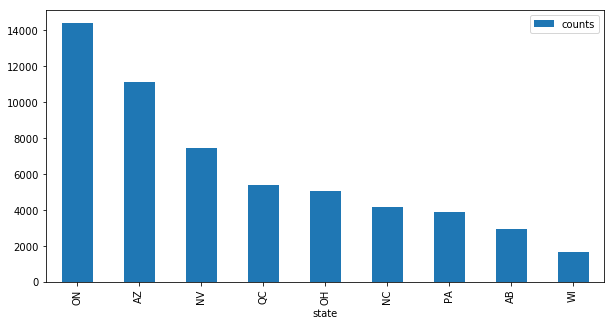

In [3]:
grouped = restaurants_df.groupby('state').size().reset_index(name='counts')
grouped_by_count_gt_1000 = grouped[grouped.counts > 1000].sort_values(by='counts',ascending = False)
grouped_by_count_gt_1000.plot.bar(x='state', y='counts',figsize=(10,5),fontsize=(10))


In [4]:
# Based on above grave we will pick one of states with higher restaurants in United states - say NV

In [5]:
state_code = 'NV'
state_restaurants = restaurants_df[restaurants_df.state == state_code]
restaurant_ids = set(state_restaurants.business_id.values)

def load_user_reviews_by_business(filename,restaurant_ids):
    reviews = []
    with open(filename,'r',encoding='utf-8') as f:
        for line in f:
            row = json.loads(line)
            business_id = row['business_id']
            if business_id in restaurant_ids:
                reviews.append(row)
    
    return pd.DataFrame(reviews)

state_restaurant_reviews_df = load_user_reviews_by_business(restaurant_reviews_latest_data_path,restaurant_ids)
state_restaurant_reviews_df.shape


(482215, 5)

In [6]:
state_restaurant_reviews_df['review_length'] = state_restaurant_reviews_df.text.map(len)
star1_df = state_restaurant_reviews_df[state_restaurant_reviews_df.stars == 1]
star1_df.shape

(65788, 6)

(107, 3)


[]

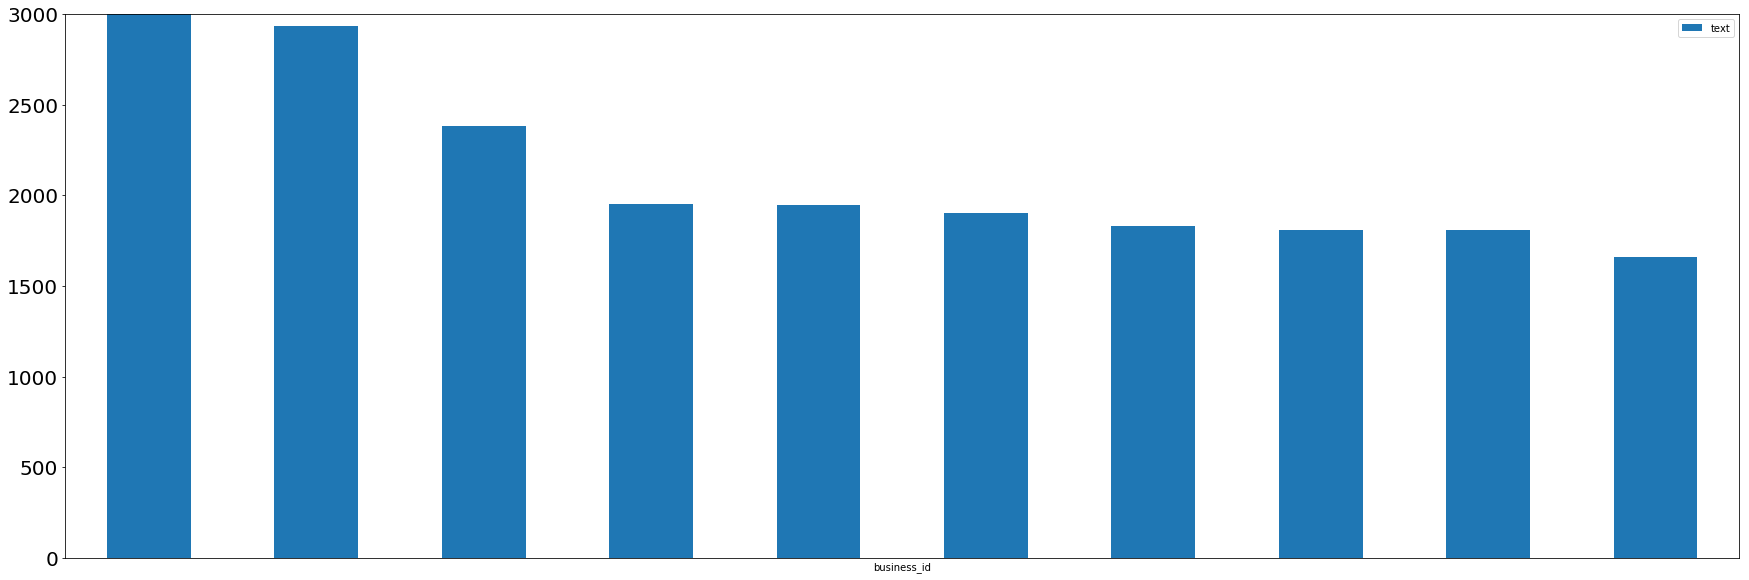

In [7]:
agg_columns = {'text':'count','review_length':'mean'}
agg_by_business_df = state_restaurant_reviews_df.groupby('business_id').agg(agg_columns).reset_index()
agg_by_business_text_count = agg_by_business_df[agg_by_business_df.text > 500]
print(agg_by_business_text_count.shape)
to_show = agg_by_business_text_count.sort_values(by='text',ascending=False)
to_show.iloc[:10,:].plot.bar(x='business_id', y='text',ylim=(0,3000),figsize=(30,10),fontsize=(20)).set_xticks([])

[]

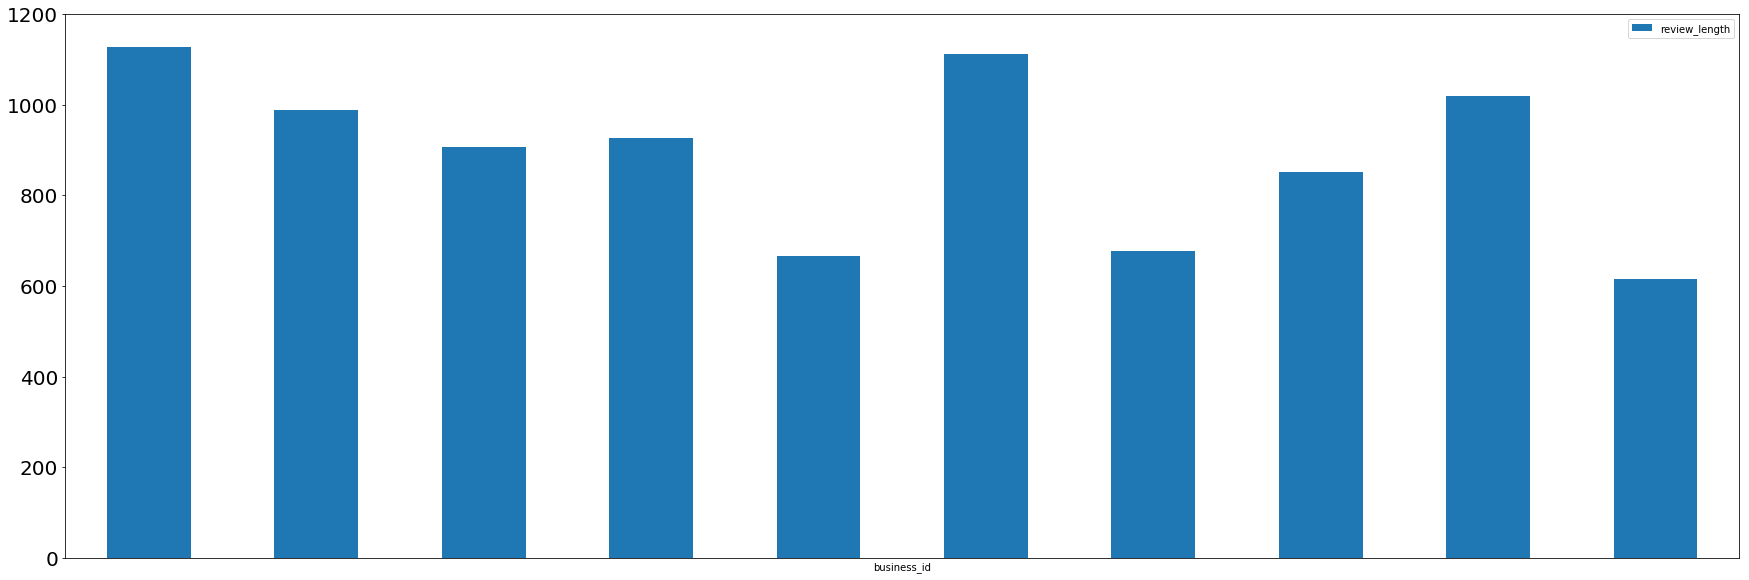

In [8]:
to_show.iloc[:10,:].plot.bar(x='business_id', y='review_length',ylim=(0,1200),figsize=(30,10),fontsize=(20)).set_xticks([])

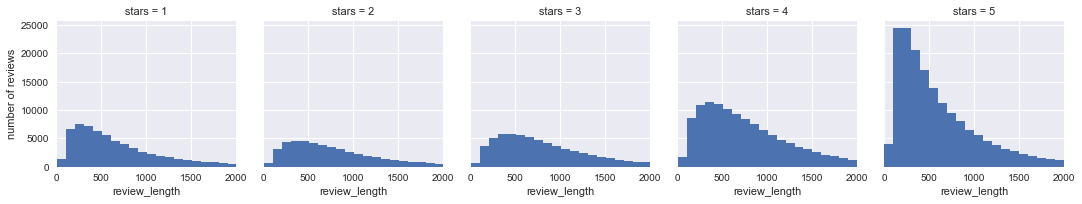

In [9]:
import seaborn as sns
sns.set()
ax = sns.FacetGrid(data=state_restaurant_reviews_df, col='stars', xlim=(0, 2000)).map(plt.hist, 'review_length', bins=50)
ax.axes[0][0].set(ylabel='number of reviews');

In [10]:
pos_reviews = state_restaurant_reviews_df.text[state_restaurant_reviews_df.stars>3].values
neg_reviews = state_restaurant_reviews_df.text[state_restaurant_reviews_df.stars<3].values
print('Postive Reviews:  {:,}'.format(len(pos_reviews)))
print('Negative Reviews:  {:,}'.format(len(neg_reviews)))


Postive Reviews:  299,253
Negative Reviews:  116,024


In [11]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_pos = TfidfVectorizer(stop_words='english', min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

tfidf_neg = TfidfVectorizer(stop_words='english', min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

neg_vectors = tfidf_neg.fit_transform(neg_reviews)
pos_vectors = tfidf_pos.fit_transform(pos_reviews)

Wall time: 1min 10s


In [12]:
%%time

from sklearn.decomposition import NMF

# change num_topics  start with 6 then go to 7 8 9 10 and 15 , you can see that 9 gives the best MSE ,RMSE and pearson
num_topics = 6

nmf_pos = NMF(n_components=num_topics)
W_pos = nmf_pos.fit_transform(pos_vectors)
H_pos = nmf_pos.components_

nmf_neg = NMF(n_components=num_topics)
W_neg = nmf_neg.fit_transform(neg_vectors)
H_neg = nmf_neg.components_

Wall time: 2min 7s


In [13]:
def display_topics(model, feature_names, num_topics, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        if topic_idx < num_topics:
            print("{:11}".format("Topic %d:" %(topic_idx)), end='')
            print(", ".join(['{:04.3f}*'.format(topic[i])+feature_names[i] \
                             for i in topic.argsort()[:-no_top_words-1:-1]]))

no_topics = num_topics
no_top_words = 8

print('Top topics + words for POSITIVE reviews')
print('-'*39)
display_topics(nmf_pos, tfidf_pos.get_feature_names(), no_topics, no_top_words)

print('\nTop topics + words for NEGATIVE reviews')
print('-'*39)
display_topics(nmf_neg, tfidf_neg.get_feature_names(), no_topics, no_top_words)

Top topics + words for POSITIVE reviews
---------------------------------------
Topic 0:   1.423*just, 1.383*like, 1.337*good, 1.290*time, 1.171*vegas, 1.101*really, 1.041*got, 1.023*buffet
Topic 1:   5.771*pizza, 0.876*crust, 0.531*slice, 0.483*cheese, 0.466*pepperoni, 0.420*pizzas, 0.417*toppings, 0.407*good
Topic 2:   3.983*great, 2.306*place, 2.175*service, 1.301*love, 1.278*friendly, 1.265*amazing, 1.184*staff, 0.874*awesome
Topic 3:   5.020*sushi, 1.385*rolls, 1.321*roll, 1.050*ayce, 0.869*fish, 0.758*fresh, 0.647*eat, 0.555*tuna
Topic 4:   2.396*chicken, 1.347*rice, 1.311*good, 1.235*thai, 1.212*fried, 0.935*spicy, 0.856*pork, 0.850*sauce
Topic 5:   4.669*burger, 2.494*fries, 1.404*burgers, 0.768*cheese, 0.571*shake, 0.493*good, 0.452*bacon, 0.395*truffle

Top topics + words for NEGATIVE reviews
---------------------------------------
Topic 0:   3.479*buffet, 1.950*sushi, 0.827*crab, 0.678*price, 0.675*quality, 0.638*vegas, 0.638*buffets, 0.587*legs
Topic 1:   1.609*minutes, 1.6

In [14]:
print('Topic weights : ', W_pos[0])
print('Sum of weights: ', W_pos[0].sum())

Topic weights :  [ 0.00267777  0.          0.00403232  0.0029523   0.0367591   0.        ]
Sum of weights:  0.0464214892027


In [15]:
from sklearn.preprocessing import normalize
print('Normalized Topic weights : ', normalize(W_pos[0].reshape(1,-1), norm='l1'))
print('Sum of normalized weights: ', normalize(W_pos[0].reshape(1,-1), norm='l1').sum())

Normalized Topic weights :  [[ 0.05768395  0.          0.08686315  0.06359768  0.79185522  0.        ]]
Sum of normalized weights:  1.0


In [16]:
state_restaurant_pos_reviews_df = state_restaurant_reviews_df[['business_id', 'stars', 'text', 'review_length']][state_restaurant_reviews_df.stars>3].reset_index()
state_restaurant_neg_reviews_df = state_restaurant_reviews_df[['business_id', 'stars', 'text', 'review_length']][state_restaurant_reviews_df.stars<3].reset_index()
state_restaurant_pos_reviews_df.drop(labels='index', axis=1, inplace=True)
state_restaurant_neg_reviews_df.drop(labels='index', axis=1, inplace=True)
print(state_restaurant_pos_reviews_df.shape)
print(state_restaurant_neg_reviews_df.shape)

(299253, 4)
(116024, 4)


In [17]:
state_restaurant_pos_reviews_cm = pd.concat([state_restaurant_pos_reviews_df, pd.DataFrame(normalize(W_pos, norm='l1'))], axis=1)
state_restaurant_neg_reviews_cm = pd.concat([state_restaurant_neg_reviews_df, pd.DataFrame(normalize(W_neg, norm='l1'))], axis=1)


In [18]:
state_restaurant_pos_reviews_cm.drop(labels='text', axis=1, inplace=True)
state_restaurant_pos_reviews_cm.drop(labels='review_length', axis=1, inplace=True)
state_restaurant_neg_reviews_cm.drop(labels='text', axis=1, inplace=True)
state_restaurant_neg_reviews_cm.drop(labels='review_length', axis=1, inplace=True)

In [19]:
agg_topic_vector_columns = {x:'mean' for x in range(num_topics)}
agg_topic_vector_columns['stars'] = 'mean'

df_pos_bsns = state_restaurant_pos_reviews_cm.groupby('business_id').agg(agg_topic_vector_columns).reset_index()
df_neg_bsns = state_restaurant_neg_reviews_cm.groupby('business_id').agg(agg_topic_vector_columns).reset_index()

In [20]:
df_pos_bsns.head()

,business_id,0,1,2,3,4,5,stars
0,--9e1ONYQuAa-CB_Rrw7Tw,0.661372,0.010587,0.212458,0.012336,0.074231,0.029015,4.641723
1,--FBCX-N37CMYDfs790Bnw,0.337746,0.014986,0.429167,0.009242,0.089232,0.119626,4.428571
2,--q7kSBRb0vWC8lSkXFByA,0.027603,0.477268,0.132296,0.010704,0.028088,0.324042,4.500000
3,-1m9o3vGRA8IBPNvNqKLmA,0.590716,0.030477,0.268026,0.007802,0.048554,0.054426,4.826087
4,-1vfRrlnNnNJ5boOVghMPA,0.079194,0.006186,0.180242,0.618365,0.113164,0.002849,4.750000


In [21]:
df_neg_bsns.head()

,business_id,0,1,2,3,4,5,stars
0,--9e1ONYQuAa-CB_Rrw7Tw,0.063639,0.206793,0.002220,0.448533,0.032714,0.246102,1.718310
1,--FBCX-N37CMYDfs790Bnw,0.018677,0.215084,0.024083,0.217560,0.053201,0.471396,1.416667
2,-153AjTW5luZPK4omEujWA,0.000000,0.000000,0.110162,0.510875,0.203226,0.175737,2.000000
3,-1m9o3vGRA8IBPNvNqKLmA,0.043719,0.176848,0.001705,0.585309,0.034363,0.158055,1.666667
4,-1vfRrlnNnNJ5boOVghMPA,0.205942,0.313790,0.008052,0.370344,0.001085,0.100787,1.500000


In [22]:
merged_business_topic_df = pd.merge(df_pos_bsns, df_neg_bsns, on='business_id', how='outer',suffixes=('_pos', '_neg'))
merged_business_topic_df.head()

,business_id,0_pos,1_pos,2_pos,3_pos,4_pos,5_pos,stars_pos,0_neg,1_neg,2_neg,3_neg,4_neg,5_neg,stars_neg
0,--9e1ONYQuAa-CB_Rrw7Tw,0.661372,0.010587,0.212458,0.012336,0.074231,0.029015,4.641723,0.063639,0.206793,0.002220,0.448533,0.032714,0.246102,1.718310
1,--FBCX-N37CMYDfs790Bnw,0.337746,0.014986,0.429167,0.009242,0.089232,0.119626,4.428571,0.018677,0.215084,0.024083,0.217560,0.053201,0.471396,1.416667
2,--q7kSBRb0vWC8lSkXFByA,0.027603,0.477268,0.132296,0.010704,0.028088,0.324042,4.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-1m9o3vGRA8IBPNvNqKLmA,0.590716,0.030477,0.268026,0.007802,0.048554,0.054426,4.826087,0.043719,0.176848,0.001705,0.585309,0.034363,0.158055,1.666667
4,-1vfRrlnNnNJ5boOVghMPA,0.079194,0.006186,0.180242,0.618365,0.113164,0.002849,4.750000,0.205942,0.313790,0.008052,0.370344,0.001085,0.100787,1.500000


In [23]:
merged_business_topic_df = merged_business_topic_df.fillna(0)
merged_business_topic_df = pd.merge(merged_business_topic_df,restaurants_df,on='business_id',how='inner')
merged_business_topic_df.head()

,business_id,0_pos,1_pos,2_pos,3_pos,4_pos,5_pos,stars_pos,0_neg,1_neg,2_neg,3_neg,4_neg,5_neg,stars_neg,stars,state
0,--9e1ONYQuAa-CB_Rrw7Tw,0.661372,0.010587,0.212458,0.012336,0.074231,0.029015,4.641723,0.063639,0.206793,0.002220,0.448533,0.032714,0.246102,1.718310,4.0,NV
1,--FBCX-N37CMYDfs790Bnw,0.337746,0.014986,0.429167,0.009242,0.089232,0.119626,4.428571,0.018677,0.215084,0.024083,0.217560,0.053201,0.471396,1.416667,4.0,NV
2,--q7kSBRb0vWC8lSkXFByA,0.027603,0.477268,0.132296,0.010704,0.028088,0.324042,4.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.0,NV
3,-1m9o3vGRA8IBPNvNqKLmA,0.590716,0.030477,0.268026,0.007802,0.048554,0.054426,4.826087,0.043719,0.176848,0.001705,0.585309,0.034363,0.158055,1.666667,4.5,NV
4,-1vfRrlnNnNJ5boOVghMPA,0.079194,0.006186,0.180242,0.618365,0.113164,0.002849,4.750000,0.205942,0.313790,0.008052,0.370344,0.001085,0.100787,1.500000,3.0,NV


In [24]:
pos_feature_names = [str(x)+'_pos' for x in range(num_topics)]
neg_feature_names = [str(x)+'_neg' for x in range(num_topics)]
feature_cols = pos_feature_names + neg_feature_names
X = merged_business_topic_df.loc[:, feature_cols]
X.shape
Y = merged_business_topic_df.loc[:, ['stars']].values.ravel()
Y.shape

(7259,)

In [25]:
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from math import sqrt

from sklearn.svm import SVR

def run_supervised(X_Train,Y_Train,X_Test,Y_Test):

    model = SVR(gamma='scale', C=1.0, epsilon=0.2)
    model.fit(X_Train,Y_Train)
    Y_Pred = model.predict(X_Test)
    MSE = mean_squared_error(Y_Test,Y_Pred)
    print(MSE)
    Pearsons_coefficient,p_value = pearsonr(Y_Test,Y_Pred)
    print("MSE " + str(MSE),"Pearsons " + str(Pearsons_coefficient))
    print("RMSE"+ str(sqrt(MSE)))

split = int(0.85 * Y.shape[0])
X_Train = X[:split]
Y_Train = Y[:split]

X_Test = X[split:]
Y_Test = Y[split:]

run_supervised(X_Train,Y_Train,X_Test,Y_Test)

0.99018697982
MSE 0.99018697982 Pearsons 0.469600628949
RMSE0.9950813935654568
